# Part II - Fordgobike Tripdata Overview

## Investigation Overview


> 1) **Customers ride far longer than Subscribers**: Median customer trip ≈ 13 min vs subscriber trip ≈ 8 min.
> 2) **Ride length depends on time context**: Subscribers peak at commute hours on weekdays; Customers ride longest midday, especially on weekends.
> 3) **Bike-Share-for-All(low-income pass) is used almost exclusively by Subscribers**: The program appears to retain low-income members rather than convert casual riders.

## Dataset Overview and Executive Summary

| Item            | Detail                                                                                                                                                                                   |
| --------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| File            | `201902-fordgobike-tripdata.csv`                                                                                                                                                         |
| Rows            | **183 412** trips                                                                                                                                                                        |
| Columns         | 16                                                                                                                                                                                       |
| Key fields used | `duration_sec` (trip length) • `user_type` (Subscriber / Customer) • `start_time` (timestamp → hour & weekday) • `member_birth_year` (→ age) • `bike_share_for_all_trip` (Yes / No flag) |


In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [5]:
# pre-processing
# 1. Cap duration at 95th percentile for cleaner plots
dur_cap = df['duration_sec'].quantile(0.95)
df['duration_sec_clip'] = df['duration_sec'].clip(upper=dur_cap)

# 2. Rider age
current_year = 2019
df['rider_age'] = current_year - df['member_birth_year']

# 3. Time features
df['start_time'] = pd.to_datetime(df['start_time'])
df['start_hour'] = df['start_time'].dt.hour
df['weekday_type'] = np.where(df['start_time'].dt.dayofweek < 5, 'Weekday', 'Weekend')
sns.set(style='whitegrid')

## Visualization 1 - Trip Duration by User Type

> Customer's median ride(\~780s) is about 60% longer then subscriber'(\~500s), and their IQR is wider-evidence that casual users treat the system as a leisure/tourism option.

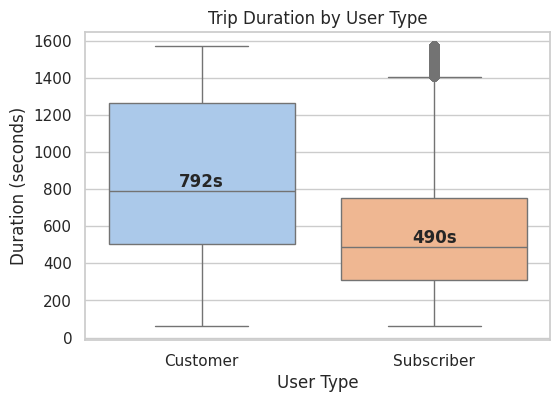

In [6]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='user_type', y='duration_sec_clip', palette='pastel')
plt.title('Trip Duration by User Type')
plt.xlabel('User Type')
plt.ylabel('Duration (seconds)')

# Annotate medians
medians = df.groupby('user_type')['duration_sec_clip'].median()
for i, m in enumerate(medians):
    plt.text(i, m+20, f'{m:.0f}s', ha='center', fontweight='bold')
plt.show()

## Visualization 2 - Mean Trip Duration by Hour

> Subscribers follow a commute-hour pattern on weekdays (peaks at 08h & 17h, about 550s) and flatten on weekends.
Customers ride longest from 10h-15h, surging to 900-1000s on weekend afternoons - classic leisure behaviour.

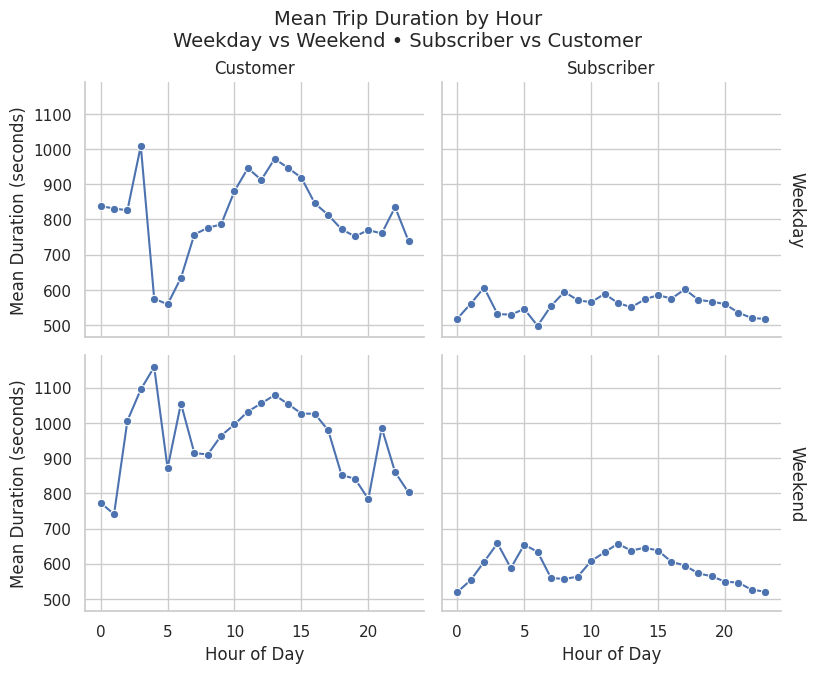

In [9]:
# Aggregate mean duration per hour, weekday/weekend, user type
hourly = (df.groupby(['weekday_type', 'user_type', 'start_hour'])
          ['duration_sec_clip'].mean().reset_index())

g = sns.FacetGrid(hourly,
                 row='weekday_type', col='user_type',
                 height=3.2, aspect=1.3, margin_titles=True)

g.map_dataframe(sns.lineplot,
               x='start_hour', y='duration_sec_clip',
               marker='o')

g.set_axis_labels('Hour of Day', 'Mean Duration (seconds)')
g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.fig.suptitle('Mean Trip Duration by Hour\nWeekday vs Weekend • Subscriber vs Customer',
              y=1.05, fontsize=14)
plt.show()

## Visualization 3 - Bike-Share-for-All Usage by User Type

> Nearly all discounted rides come from subscribers; customer uptake is negligible. The program appears to retain low-income members rather than recruit new casual riders.

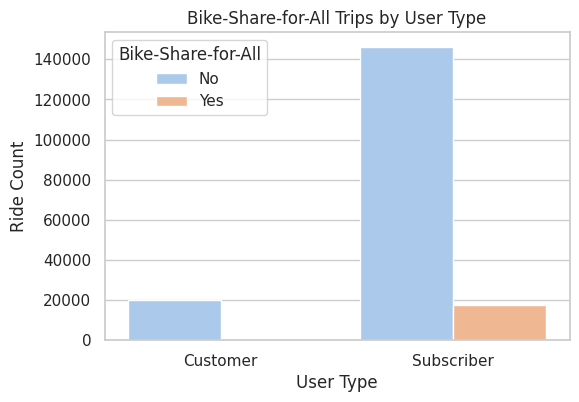

In [11]:
share_counts = (df.groupby(['user_type', 'bike_share_for_all_trip'])
               .size().reset_index(name='count'))
plt.figure(figsize=(6, 4))
sns.barplot(data=share_counts,
           x='user_type', y='count',
           hue='bike_share_for_all_trip',
           palette='pastel')
plt.title('Bike-Share-for-All Trips by User Type')
plt.xlabel('User Type')
plt.ylabel('Ride Count')
plt.legend(title='Bike-Share-for-All')
plt.show()